Sine Wave:
  Dominant Frequency: 50.00 Hz
  Amplitude: 0.50
  Phase: -1.41 radians

Cosine Wave:
  Dominant Frequency: 50.00 Hz
  Amplitude: 0.50
  Phase: 0.16 radians


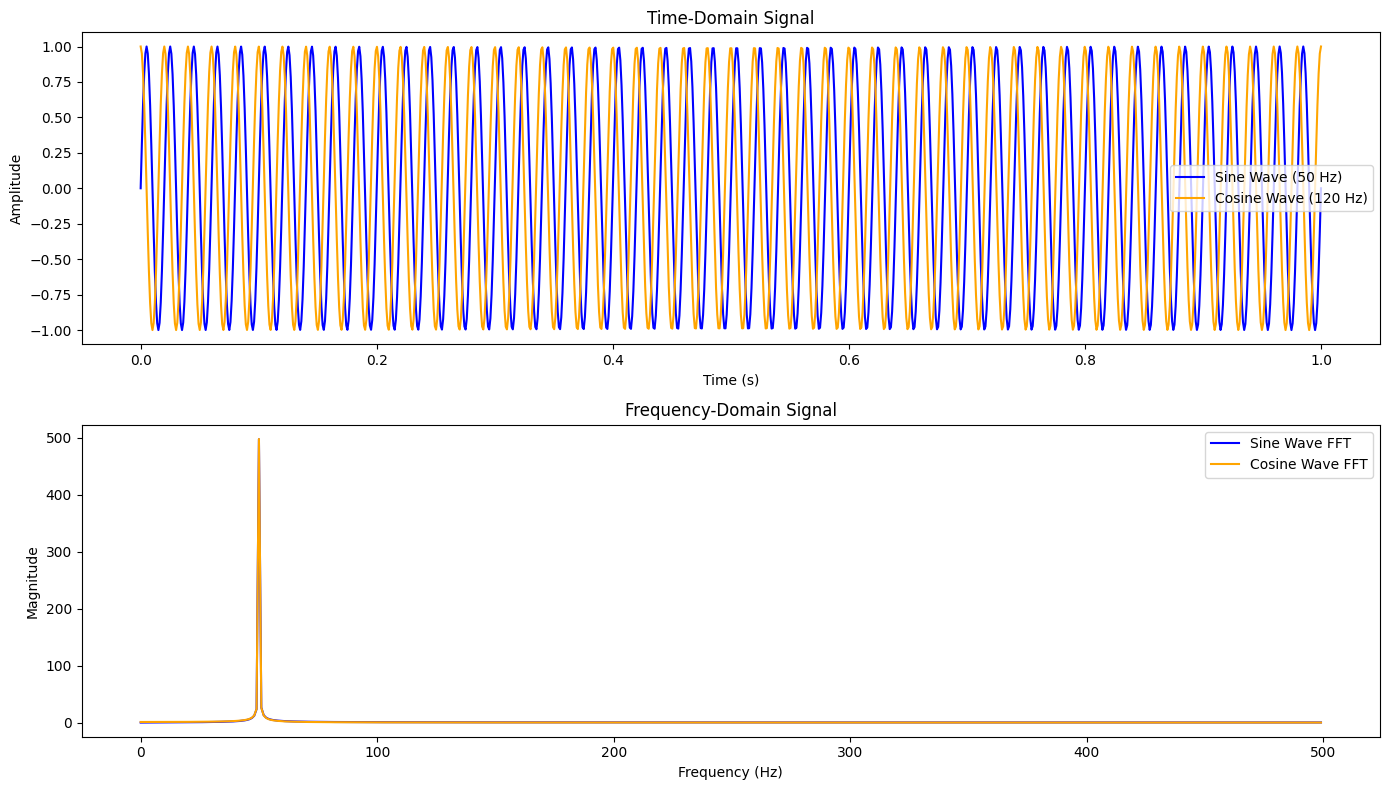

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Generate sample DataFrame with sine and cosine signals
fs = 1000  # Sampling frequency (Hz)
t = np.linspace(0, 1, fs)  # Time vector (1 second)
f_sin = 50  # Frequency of sine wave (Hz)
f_cos = 50  # Frequency of cosine wave (Hz)

# Create DataFrame with sine and cosine signals
df = pd.DataFrame({
    'time': t,
    'sine_wave':   np.sin(2 * np.pi * f_sin * t),
    'cosine_wave': np.cos(2 * np.pi * f_cos * t) 
})

# Function to calculate FFT properties
def analyze_signal(df, col_name):
    fft_result = np.fft.fft(df[col_name])
    freqs = np.fft.fftfreq(len(df[col_name]), d=(1/fs))
    
    # Find dominant frequency
    dominant_freq_index = np.argmax(np.abs(fft_result[:len(freqs)//2]))  # Only positive frequencies
    dominant_freq = freqs[dominant_freq_index]
    amplitude = np.abs(fft_result[dominant_freq_index]) / len(df[col_name])
    phase = np.angle(fft_result[dominant_freq_index])
    
    return dominant_freq, amplitude, phase

# Analyze sine wave
dominant_freq_sine, amplitude_sine, phase_sine = analyze_signal(df, 'sine_wave')

# Analyze cosine wave
dominant_freq_cosine, amplitude_cosine, phase_cosine = analyze_signal(df, 'cosine_wave')

# Print results
print("Sine Wave:")
print(f"  Dominant Frequency: {dominant_freq_sine:.2f} Hz")
print(f"  Amplitude: {amplitude_sine:.2f}")
print(f"  Phase: {phase_sine:.2f} radians")

print("\nCosine Wave:")
print(f"  Dominant Frequency: {dominant_freq_cosine:.2f} Hz")
print(f"  Amplitude: {amplitude_cosine:.2f}")
print(f"  Phase: {phase_cosine:.2f} radians")

# Plot signals
plt.figure(figsize=(14, 8))

# Time-domain plots
plt.subplot(2, 1, 1)
plt.plot(df['time'], df['sine_wave'], label="Sine Wave (50 Hz)", color='blue')
plt.plot(df['time'], df['cosine_wave'], label="Cosine Wave (120 Hz)", color='orange')
plt.title("Time-Domain Signal")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()

# Frequency-domain plots
plt.subplot(2, 1, 2)
fft_sine = np.fft.fft(df['sine_wave'])
fft_cosine = np.fft.fft(df['cosine_wave'])
freqs = np.fft.fftfreq(len(df['sine_wave']), d=(1/fs))

plt.plot(freqs[:len(freqs)//2], np.abs(fft_sine[:len(freqs)//2]), label="Sine Wave FFT", color='blue')
plt.plot(freqs[:len(freqs)//2], np.abs(fft_cosine[:len(freqs)//2]), label="Cosine Wave FFT", color='orange')
plt.title("Frequency-Domain Signal")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.legend()

plt.tight_layout()
plt.show()


Dominant Frequency: 0.0140 Hz


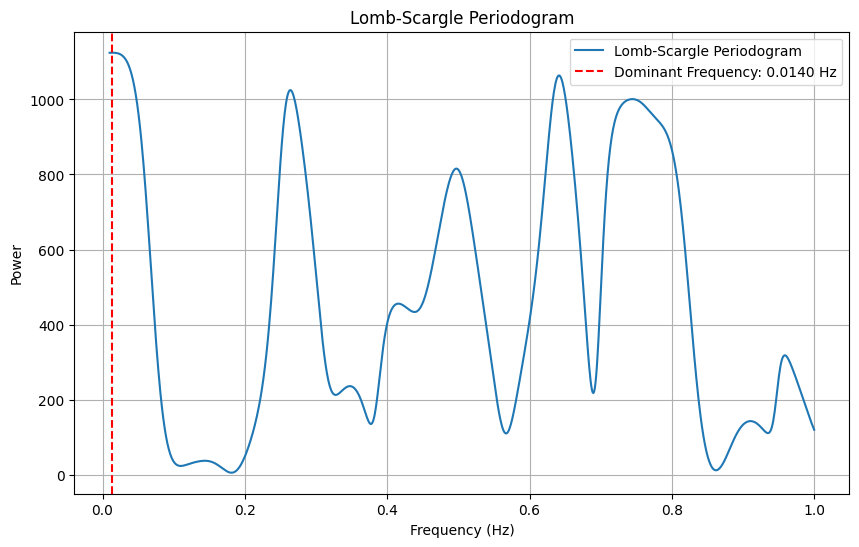

In [33]:
from scipy.signal import lombscargle

# 假設數據
timestamps = np.array([0, 1.5, 3.7, 5.2, 7.9]) + 99999  # 非均勻時間
values = np.array([10, 15, 20, 25, 30])          # 對應的數值

# 設定頻率範圍
freqs = np.linspace(0.01, 1, 1000)  # 掃描的頻率範圍

# 計算 Lomb-Scargle Power
angular_freqs = 2 * np.pi * freqs
power = lombscargle(timestamps, values, angular_freqs)

# 找出 dominant frequency
dominant_freq_index = np.argmax(power)
dominant_freq = freqs[dominant_freq_index]

# 輸出結果
print(f"Dominant Frequency: {dominant_freq:.4f} Hz")

# 繪製結果
plt.figure(figsize=(10, 6))
plt.plot(freqs, power, label="Lomb-Scargle Periodogram")
plt.axvline(x=dominant_freq, color='r', linestyle='--', label=f"Dominant Frequency: {dominant_freq:.4f} Hz")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power")
plt.legend()
plt.grid()
plt.title("Lomb-Scargle Periodogram")
plt.show()


<a href="https://colab.research.google.com/github/Brownwang0426/Reversal-Generative-Reinforcement-Learning/blob/main/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing requirements (for colab)

In [ ]:
!sudo apt-get install python3.10

In [ ]:
!pip install pandas==2.0.3 numpy==1.25.2 scipy==1.11.4 swig==4.2.1 ufal.pybox2d==2.3.10.3 gym==0.25.2 pygame==2.5.2 tqdm torch==2.0.1

# Cloning git (for colab)

In [ ]:
!git clone https://github.com/Brownwang0426/Reversal-Generative-Reinforcement-Learning.git

# Changing directory (for colab)

In [ ]:
import os
os.chdir('/content/Reversal-Generative-Reinforcement-Learning')

# Importing modules

In [ ]:
import gym

import numpy as np
import math
from scipy.special import softmax

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.utils.rnn as rnn_utils
from torch.utils.data import DataLoader, TensorDataset, Subset

import csv

import multiprocessing as mp
import os
import sys
import copy
import random
import gc
import time
from tqdm import tqdm
from collections import defaultdict

import itertools

# Checking cuda

In [ ]:
if torch.cuda.is_available():
    for i in range(torch.cuda.device_count()):
        print(f"Device {i}: {torch.cuda.get_device_name(i)}")
    device_index = 0
    device = torch.device(f"cuda:{device_index}")
    print('using cuda...')
else:
    device = torch.device("cpu")
    print('using cpu...')
assert device != torch.device("cpu") # Sorry, but we really recommend you to run it on GPU :-) Nvidia needs your money :-)

In [ ]:
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True

# Control board

Crucial configurations regarding how your agent will learn in the environment. The meanings are as follow:
(the configs starting with ⚠️ are what we suggest you must tune according to your specific need in your task)
(the configs starting with ◀️ are what we suggest you to play with to see the effect)

| Configs   | Type   | Description                                                                 |
|------------|--------|-----------------------------------------------------------------------------|
| ⚠️game_name  | STR| The name of the environment.                                |
| ⚠️max_steps_for_each_episode | +INT | The maximun steps that the agent will go through while not done. In some environments, it is crucial to increase your "max_steps_for_each_episode" so that your agent can "live long enough" to obatin some better rewards to gradually and heuristically learn better strategy.                    |
| ◀️ensemble_size  | +INT | The size of the neural ensemble which the agent is comprised of. The bigger, the better, but the longer training time without parallel training. :-D                  |
| ⚠️state_size  | +INT | The size of the state as input data.                    |
| ⚠️hidden_size   | +INT |The size of the hidden layers. We suggest hidden_size >= state_size.           |
| ⚠️action_size   | +INT | The size of action per step as input data.   |
| ⚠️time_size  | +INT |The length of the sequence of actions. Namely, how many steps in the future the agent will predict or use to discern the present best action.                |
| ⚠️reward_size  | +INT |The size of the reward as output data.                          |
| ⚠️neural_type  | STR |  [**`rnn`**, **`gru`**, **`lstm`**, **`rnn_att`**] The type of neural network you prefer. For now, we support rnn, gru, lstm, and rnn_att (recurrent attention). More to come in the future (or you can build one yourself :-D in the models repository).           |
| ⚠️num_layers  | +INT |The number of layers in rnn, gru, lstm, and rnn_att (recurrent attention). We suggest no less than 3 (>= 3) to provide more flexibility and memory capacity for neural networks.                         |
| ⚠️num_heads  | +INT/None |The number of heads in multi-head attention (Should be able to devide hidden_size) (Should be None for non-attention neural_type).                         |
| hidden_activation  | STR | [**`relu`**, **`leaky_relu`**, **`sigmoid`**, **`tanh`**] The type of activation function in the hidden layers.              |
| output_activation  | STR | [**`relu`**, **`leaky_relu`**, **`sigmoid`**, **`tanh`**] The type of activation function in the output layer.                      |
| shift  | 0/±FLOAT |The value in f(x+shift) where f(x) is activation function in the output layer. This value is interesting. If this value is negatively large, the agent will act more conservatively and prone to exploit known strategy. If this value is positively large, the agent to act more radically and prone to explore all possible strategies before settling down. We humorously refer to this variable as the "playboy variable," drawing an analogy to individuals who change partners frequently in search of the ideal match because the individuals always think there might be better choice :-P But we can't really write this into the paper... you know...             |
| init   | STR | [**`random_normal`**, **`random_uniform`**, **`xavier_normal`**, **`xavier_uniform`**, **`glorot_normal`**, **`glorot_uniform`**] The initialization method you prefer.                          |
| opti   | STR | [**`adam`**, **`sgd`**, **`rmsprop`**]  The optimization method you prefer.             |
| loss  | STR | [**`mean_squared_error`**, **`binary_crossentropy`**] The loss or error function you prefer.                           |
| bias  | BOLEAN |Whether you want add bias.                          |
| drop_rate   | 0/+FLOAT |The drop-rate for drop-out.              |
| ⚠️alpha   | 0/+FLOAT |The learning rate for neural networks weight matrices.                           |
| ⚠️epoch_for_learning   | +INT |The iteration for learning.              |
| load_pre_model  | BOLEAN |Whether you want to load previous trained model.                          |
| noise_t  |  +INT |The times applying gaussian noise to the initializated actions of the agent, similar to diffusion model's adding gaussian noise.          |
| ⚠️noise_r  |  0/+FLOAT |The noise range to the initializated actions of the agent. The higher the value is, the more exploration-oriented the agent will be.                    |
| ⚠️beta  |  0/+FLOAT |The updating rate for updating actions of the agent.              |
| ⚠️epoch_for_deducing  |  +INT |The iteration for updating actions of the agent.                           |
| episode_for_training  | +INT |How many epsiodes will your agent run in the training mode where your agent will learn offline.              |
| chunk_size  | +INT |The maximum chunk size for sequentializing state, action, reward. We suggest chunk_size <= time_size.      |
| batch_size_for_offline_learning  |+INT | After how many epsodes will your agent start learning from experience buffer.                           |
| PER_epsilon  | 0/+FLOAT |The epsilon for prioritized experience replay.              |
| PER_exponent  | 0/+FLOAT |The expoenet for prioritized experience replay.                           |
| episode_for_testing  | +INT |How many epsiodes will your agent run in the testing mode where your agent will not learn offline.                        |
| render_for_human  | BOLEAN | Wether you want to render the visual result for each step in the testing mode.              |


## frozen lake

In [ ]:
game_name =  'FrozenLake-v1'        #⚠️ gym.make(game_name, is_slippery=False, map_name="4x4")
max_steps_for_each_episode = 25     #⚠️


ensemble_size = 10                  #◀️
state_size =  16                    #⚠️
hidden_size = 100                   #⚠️
action_size = 4                     #⚠️
time_size = 8                       #⚠️
reward_size = 100                   #⚠️
neural_type = 'gru'                 #⚠️
num_layers = 3                      #⚠️
num_heads = None                    #⚠️
hidden_activation = 'tanh'
output_activation = 'sigmoid'
shift = 0.0
init = "random_normal"
opti = 'sgd'
loss = 'mean_squared_error'
bias = False
drop_rate = 0.0
alpha = 0.1                         #⚠️
epoch_for_learning = 1              #⚠️
load_pre_model = False


noise_t = 1
noise_r = 0.1                               #⚠️
beta = 0.1                                  #⚠️
epoch_for_deducing = int(100/ensemble_size) #⚠️


episode_for_training = 100000
chunk_size = 5
batch_size_for_offline_learning = 1
iteration_for_TD_error = 1000
PER_epsilon = 0.000001
PER_exponent = 5


episode_for_testing = 100
render_for_human = True



## blackjack

In [ ]:
game_name = 'Blackjack-v1'          #⚠️
max_steps_for_each_episode = 10     #⚠️


ensemble_size = 5                   #◀️
state_size =  201                   #⚠️
hidden_size = 250                   #⚠️
action_size = 2                     #⚠️
time_size = 5                       #⚠️
reward_size = 100                   #⚠️
neural_type = 'gru'                 #⚠️
num_layers = 3                      #⚠️
num_heads = None                    #⚠️
hidden_activation = 'tanh'
output_activation = 'sigmoid'
shift = 0.0
init = "random_normal"
opti = 'sgd'
loss = 'mean_squared_error'
bias = False
drop_rate = 0.0
alpha = 0.1                         #⚠️
epoch_for_learning = 1              #⚠️
load_pre_model = False


noise_t = 1
noise_r = 0.1                               #⚠️
beta = 0.1                                  #⚠️
epoch_for_deducing = int(100/ensemble_size) #⚠️


episode_for_training = 100000
chunk_size = 5
batch_size_for_offline_learning = 100
iteration_for_TD_error = 1000
PER_epsilon = 0.000001
PER_exponent = 2


episode_for_testing = 100
render_for_human = True



## cartpole

In [ ]:
game_name = 'CartPole-v1'           #⚠️
max_steps_for_each_episode = 2000   #⚠️


ensemble_size = 10                  #◀️
state_size =  400                   #⚠️
hidden_size = 400                   #⚠️
action_size = 2                     #⚠️
time_size = 25                      #⚠️
reward_size = 100                   #⚠️
neural_type = 'gru'                 #⚠️
num_layers = 3                      #⚠️
num_heads = None                    #⚠️
hidden_activation = 'tanh'
output_activation = 'sigmoid'
shift = 0.0
init = "random_normal"
opti = 'sgd'
loss = 'mean_squared_error'
bias = False
drop_rate = 0.0
alpha = 0.1                         #⚠️
epoch_for_learning = 1              #⚠️
load_pre_model = False


noise_t = 1
noise_r = 0.1                               #⚠️
beta = 0.1                                  #⚠️
epoch_for_deducing = int(100/ensemble_size) #⚠️


episode_for_training = 100000
chunk_size = 25
batch_size_for_offline_learning = 1
iteration_for_TD_error = 1000
PER_epsilon = 0.000001
PER_exponent = 2


episode_for_testing = 100
render_for_human = True



## mountain car

In [ ]:
game_name =  'MountainCar-v0'       #⚠️
max_steps_for_each_episode = 200    #⚠️


ensemble_size = 10                  #◀️
state_size =  200                   #⚠️
hidden_size = 200                   #⚠️
action_size = 3                     #⚠️
time_size = 50                      #⚠️
reward_size = 100                   #⚠️
neural_type = 'gru'                 #⚠️
num_layers = 3                      #⚠️
num_heads = None                    #⚠️
hidden_activation = 'tanh'
output_activation = 'sigmoid'
shift = 0.0
init = "random_normal"
opti = 'sgd'
loss = 'mean_squared_error'
bias = False
drop_rate = 0.0
alpha = 0.1                         #⚠️
epoch_for_learning = 1              #⚠️
load_pre_model = False


noise_t = 1
noise_r = 0.1                                 #⚠️
beta = 0.1                                    #⚠️
epoch_for_deducing = int(100/ensemble_size)   #⚠️


episode_for_training = 100000
chunk_size = 25
batch_size_for_offline_learning = 1
iteration_for_TD_error = 1000
PER_epsilon = 0.000001
PER_exponent = 2


episode_for_testing = 100
render_for_human = True



## acrobot

In [ ]:
game_name = 'Acrobot-v1'            #⚠️
max_steps_for_each_episode = 200    #⚠️


ensemble_size = 5                   #◀️
state_size =  600                   #⚠️
hidden_size = 600                   #⚠️
action_size = 3                     #⚠️
time_size = 50                      #⚠️
reward_size = 100                   #⚠️
neural_type = 'gru'                 #⚠️
num_layers = 3                      #⚠️
num_heads = None                    #⚠️
hidden_activation = 'tanh'
output_activation = 'sigmoid'
shift = 0.0
init = "random_normal"
opti = 'sgd'
loss = 'mean_squared_error'
bias = False
drop_rate = 0.0
alpha = 0.1                         #⚠️
epoch_for_learning = 1              #⚠️
load_pre_model = False


noise_t = 1
noise_r = 0.1                                 #⚠️
beta = 0.1                                    #⚠️
epoch_for_deducing = int(100/ensemble_size)   #⚠️


episode_for_training = 100000
chunk_size = 25
batch_size_for_offline_learning = 1
iteration_for_TD_error = 1000
PER_epsilon = 0.000001
PER_exponent = 2


episode_for_testing = 100
render_for_human = True



## lunar lander

In [ ]:
game_name = "LunarLander-v2"        #⚠️
max_steps_for_each_episode = 200    #⚠️


ensemble_size = 5                   #◀️
state_size =  800                   #⚠️
hidden_size = 800                   #⚠️
action_size = 4                     #⚠️
time_size = 50                      #⚠️
reward_size = 250                   #⚠️
neural_type = 'gru'                 #⚠️
num_layers = 3                      #⚠️
num_heads = None                    #⚠️
hidden_activation = 'tanh'
output_activation = 'sigmoid'
shift = 0.0
init = "random_normal"
opti = 'sgd'
loss = 'mean_squared_error'
bias = False
drop_rate = 0.0
alpha = 0.1                         #⚠️
epoch_for_learning = 1              #⚠️
load_pre_model = False


noise_t = 1
noise_r = 0.1                                 #⚠️
beta = 0.1                                    #⚠️
epoch_for_deducing = int(100/ensemble_size)   #⚠️


episode_for_training = 100000
chunk_size = 25
batch_size_for_offline_learning = 1
iteration_for_TD_error = 1000
PER_epsilon = 0.000001
PER_exponent = 2


episode_for_testing = 100
render_for_human = True



## your present config

In [ ]:
game_name =  'FrozenLake-v1'        #⚠️ 
max_steps_for_each_episode = 25     #⚠️


ensemble_size = 10                  #◀️
state_size =  16                    #⚠️
hidden_size = 100                   #⚠️
action_size = 4                     #⚠️
time_size = 8                       #⚠️
reward_size = 100                   #⚠️
neural_type = 'gru'                 #⚠️
num_layers = 3                      #⚠️
num_heads = None                    #⚠️
hidden_activation = 'tanh'
output_activation = 'sigmoid'
shift = 0.0
init = "random_normal"
opti = 'sgd'
loss = 'mean_squared_error'
bias = False
drop_rate = 0.0
alpha = 0.1                         #⚠️
epoch_for_learning = 1              #⚠️
load_pre_model = False


noise_t = 1
noise_r = 0.1                               #⚠️
beta = 0.1                                  #⚠️
epoch_for_deducing = int(100/ensemble_size) #⚠️


episode_for_training = 100000
chunk_size = 5
batch_size_for_offline_learning = 1
iteration_for_TD_error = 1000
PER_epsilon = 0.000001
PER_exponent = 10


episode_for_testing = 100
render_for_human = True



In [ ]:
suffix                      = f"game={game_name}_type={neural_type}_ensemble={ensemble_size:05d}_drop={drop_rate:.5f}_learn={epoch_for_learning:05d}_interval={batch_size_for_offline_learning:05d}_deduce={epoch_for_deducing:05d}"
directory                   = f'./result/{game_name}/'
model_directory             = f'./result/{game_name}/model_{suffix}'+'_%s.h5'
performance_log_directory   = f'./result/{game_name}/performace_log_{suffix}.csv'

# Importing local modules

In [ ]:
if   game_name == 'FrozenLake-v1':
    from envs.env_frozenlake   import vectorizing_state, vectorizing_action, vectorizing_reward
elif   game_name == 'Blackjack-v1':
    from envs.env_blackjack   import vectorizing_state, vectorizing_action, vectorizing_reward
elif   game_name == 'CartPole-v1':
    from envs.env_cartpole    import vectorizing_state, vectorizing_action, vectorizing_reward
elif game_name == 'MountainCar-v0':
    from envs.env_mountaincar import vectorizing_state, vectorizing_action, vectorizing_reward
elif game_name == 'MountainCarContinuous-v0':
    from envs.env_mountaincar_continuous import vectorizing_state, vectorizing_action, vectorizing_reward
elif game_name == 'Acrobot-v1':
    from envs.env_acrobot import vectorizing_state, vectorizing_action, vectorizing_reward
elif game_name == "Pendulum-v1":
    from envs.env_pendulum import vectorizing_state, vectorizing_action, vectorizing_reward
elif game_name == "LunarLander-v2":
    from envs.env_lunarlander import vectorizing_state, vectorizing_action, vectorizing_reward
elif game_name == 'BipedalWalker-v3':
    from envs.env_bipedalwalker import vectorizing_state, vectorizing_action, vectorizing_reward
else:
   raise RuntimeError('missing env functions')

In [ ]:
if neural_type == 'rnn_att':
    from models.model_rnn_att import build_model
    from utils.util_rnn_att   import initialize_pre_activated_action, \
                                 update_pre_activated_action, \
                                 sequentialize, \
                                 obtain_TD_error,\
                                 update_model, \
                                 save_performance_to_csv
else:
    from models.model_rnn import build_model
    from utils.util_rnn   import initialize_pre_activated_action, \
                                 update_pre_activated_action, \
                                 sequentialize, \
                                 obtain_TD_error,\
                                 update_model, \
                                 save_performance_to_csv

# Deducing -> Learning
Training mode where your agent will learn offline. You can see here how your agent learn overtime and improve its performance.

Creating or loading models

In [ ]:

if not os.path.exists(directory):
    os.makedirs(directory)

if load_pre_model == False:

    model_list = []
    for _ in range(ensemble_size):
        model = build_model(state_size,
                            hidden_size,
                            action_size,
                            time_size,
                            reward_size,
                            neural_type,
                            num_layers,
                            num_heads,
                            hidden_activation,
                            output_activation,
                            shift,
                            init,
                            opti,
                            loss,
                            bias,
                            drop_rate,
                            alpha)
        model.to(device)
        model_list.append(model)

elif load_pre_model == True:

    model_list = []
    for _ in range(ensemble_size):
        model = build_model(state_size,
                            hidden_size,
                            action_size,
                            time_size,
                            reward_size,
                            neural_type,
                            num_layers,
                            num_heads,
                            hidden_activation,
                            output_activation,
                            shift,
                            init,
                            opti,
                            loss,
                            bias,
                            drop_rate,
                            alpha)
        model.to(device)
        model_list.append(model)

    for i in range(len(model_list)):
        model_list[i].load_state_dict(torch.load( model_directory  % i ))



Creating Streams

Creating desired reward

In [ ]:
desired_reward = torch.ones((1, time_size, reward_size))

Putting all the previous works into play

In [ ]:

performance_log = []

for training_episode in tqdm(range(episode_for_training)):

    # initializing short term experience replay buffer
    short_term_state_list  = []
    short_term_action_list = []
    short_term_reward_list = []

    # initializing environment
    env                    = gym.make(game_name, is_slippery=False, map_name="4x4")
    env._max_episode_steps = max_steps_for_each_episode
    state                  = env.reset()
    summed_reward          = 0

    # observing state
    state    = vectorizing_state(state)
    short_term_state_list.append(state)

    for count in itertools.count(1):

        # initializing and updating action
        state                 = torch.tensor(np.atleast_2d(state), dtype=torch.float)
        pre_activated_action  = initialize_pre_activated_action(init, noise_t, noise_r, (time_size, action_size))
        pre_activated_action  = torch.tensor(pre_activated_action[np.newaxis, :, :], dtype=torch.float)
        pre_activated_action  = update_pre_activated_action(epoch_for_deducing,
                                                            model_list,
                                                            state,
                                                            pre_activated_action,
                                                            desired_reward,
                                                            beta,
                                                            device)
        action, action_       = vectorizing_action(pre_activated_action)
        short_term_action_list.append(action)

        # executing action
        state, reward, done, info = env.step(action_)

        # observing actual reward
        summed_reward += reward
        reward = vectorizing_reward(state, reward, summed_reward, done, reward_size)
        short_term_reward_list.append(reward)

        # observing state
        state    = vectorizing_state(state)
        short_term_state_list.append(state)

        if done:
            print(f'Episode {training_episode}: Summed_Reward = {summed_reward}')
            performance_log.append([training_episode, summed_reward])
            save_performance_to_csv(performance_log, performance_log_directory)
            break
        else:
            pass




    env.close()




    # sequentializing short term experience replay buffer
    short_term_sequentialized_state_list   ,\
    short_term_sequentialized_action_list  ,\
    short_term_sequentialized_reward_list  ,\
    short_term_sequentialized_n_state_list = sequentialize(short_term_state_list,
                                                           short_term_action_list,
                                                           short_term_reward_list, chunk_size)

    short_term_experience_replay_buffer_list = list(zip(short_term_sequentialized_state_list,
                                                        short_term_sequentialized_action_list,
                                                        short_term_sequentialized_reward_list,
                                                        short_term_sequentialized_n_state_list))

    if (training_episode==0) :
        long_term_experience_replay_buffer_list  = copy.deepcopy(short_term_experience_replay_buffer_list)
    else:
        long_term_experience_replay_buffer_list += short_term_experience_replay_buffer_list




    # dropping duplicates in buffer
    long_term_experience_replay_buffer_list = list(set(long_term_experience_replay_buffer_list))




    # batch offline learning
    if (training_episode+1) % batch_size_for_offline_learning == 0:




        classified_by_length = defaultdict(list)
        for buffer in long_term_experience_replay_buffer_list: # long_term_experience_replay_buffer_list - [(s, a, r, ns), ..., (s, a, r, ns)]
            s, a, r, ns = buffer
            length      = (len(s), len(a), len(r), len(ns))
            classified_by_length[length].append(buffer)
        classified_by_length = dict(classified_by_length)

        for key in list(classified_by_length.keys()):
            list_tuple       = classified_by_length[key]  # list_tuple - [(s, a, r, ns), ..., (s, a, r, ns)]
            list_tuple       = list(zip(*list_tuple))     # list_tuple - [(s, ..., s), (a, ..., a), (r, ..., r), (ns, ..., ns)]
            state_tuple      = list_tuple[0] # (s,  ..., s)
            action_tuple     = list_tuple[1] # (a,  ..., a)
            reward_tuple     = list_tuple[2] # (r,  ..., r)
            n_state_tuple    = list_tuple[3] # (ns, ..., ns)
            state_tensor     = torch.tensor(np.array(state_tuple  ), dtype=torch.float).to(device)   # 2d tensor [s,  ..., s]
            action_tensor    = torch.tensor(np.array(action_tuple ), dtype=torch.float).to(device)   # 2d tensor [a,  ..., a]
            reward_tensor    = torch.tensor(np.array(reward_tuple ), dtype=torch.float).to(device)   # 2d tensor [r,  ..., r]
            n_state_tensor   = torch.tensor(np.array(n_state_tuple), dtype=torch.float).to(device)   # 2d tensor [ns, ..., ns]
            classified_by_length[key] = [state_tensor, action_tensor, reward_tensor, n_state_tensor] # list of 2d tensor [[s,  ..., s], [a,  ..., a], [r,  ..., r], [ns, ..., ns]]




        for _ in range(iteration_for_TD_error):




            random_key       = random.choice(list(classified_by_length.keys()))
            list_tensor      = classified_by_length[random_key] # list of 2d tensor [[s,  ..., s], [a,  ..., a], [r,  ..., r], [ns, ..., ns]]




            index     = obtain_TD_error(model_list,
                                        list_tensor,
                                        PER_epsilon,
                                        PER_exponent,
                                        device)

            model_list   = update_model(epoch_for_learning,
                                        model_list,
                                        list_tensor,
                                        index,
                                        device)




        # saving:
        for i in range(len(model_list)):
            torch.save(model_list[i].state_dict(), model_directory % i)


        gc.collect()
        torch.cuda.empty_cache()

# Deducing only
Testing mode where your trained agent in the training mode will not learn offline. It just keeps running each episode without learning new stuff.

Loading models

In [ ]:
model_list = []
for _ in range(ensemble_size):
    model = build_model(state_size,
                        hidden_size,
                        action_size,
                        time_size,
                        reward_size,
                        neural_type,
                        num_layers,
                        num_heads,
                        hidden_activation,
                        output_activation,
                        shift,
                        init,
                        opti,
                        loss,
                        bias,
                        drop_rate,
                        alpha)
    model.to(device)
    model_list.append(model)

for i in range(len(model_list)):
    model_list[i].load_state_dict(torch.load(model_directory % i))

Creating desired reward ... again

In [ ]:
desired_reward = torch.ones((1, time_size, reward_size))

Putting all the previous works into play ... again

But this time the agent does not learn

In [ ]:
total_summed_reward = 0

for testing_episode in range(episode_for_testing):

    if render_for_human == True:
        env = gym.make( game_name, render_mode="human")
    else:
        env = gym.make( game_name)
    env._max_episode_steps = max_steps_for_each_episode
    state                  = env.reset()
    if render_for_human == True:
        env.render()
    summed_reward = 0

    state = vectorizing_state(state)

    done = False
    while not done:

        state                 = torch.tensor(np.atleast_2d(state), dtype=torch.float)
        pre_activated_action  = initialize_pre_activated_action(init, noise_t, noise_r, (time_size, action_size))
        pre_activated_action  = torch.tensor(pre_activated_action[np.newaxis, :, :], dtype=torch.float)
        pre_activated_action  = update_pre_activated_action(epoch_for_deducing,
                                                            model_list,
                                                            state,
                                                            pre_activated_action,
                                                            desired_reward,
                                                            beta,
                                                            device)
        action, action_       = vectorizing_action(pre_activated_action)

        state, reward, done,  info = env.step(action_)
        if render_for_human == True:
            env.render()

        summed_reward += reward

        state = vectorizing_state(state)

        if done:
            break

    env.close()

    print("Summed reward:", summed_reward)
    print(f'Episode: {testing_episode + 1}')
    print('Everaged summed reward:')
    total_summed_reward += summed_reward
    print(total_summed_reward/(testing_episode + 1))

